In [72]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime
from scipy.stats import zscore

In [73]:
# Load and preprocess dataset
df = pd.read_csv('GlobalWeatherRepository.csv')

In [74]:
# First few rows of the dataset
print("Dataset preview:")
print(df.head())

Dataset preview:
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66

In [75]:
# Data Cleaning: Handle missing values
missing_values = df.isnull().sum()
print("\nMissing values before cleaning:")
print(missing_values)

# Drop rows with missing values
df.dropna(inplace=True)


Missing values before cleaning:
country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozo

In [76]:
# Data normalization
scaler = MinMaxScaler()
df[['latitude', 'longitude']] = scaler.fit_transform(df[['latitude', 'longitude']])


In [77]:
# Handle Outliers: Removing temperature outliers using Z-score
df['temperature_zscore'] = zscore(df['temperature_celsius'])
df = df[df['temperature_zscore'].abs() <= 2]

In [78]:
# Convert 'last_updated' to datetime and set as index for time series
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.set_index('last_updated', inplace=True)


In [79]:
# Feature engineering: Extract time-based features for machine learning models
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour


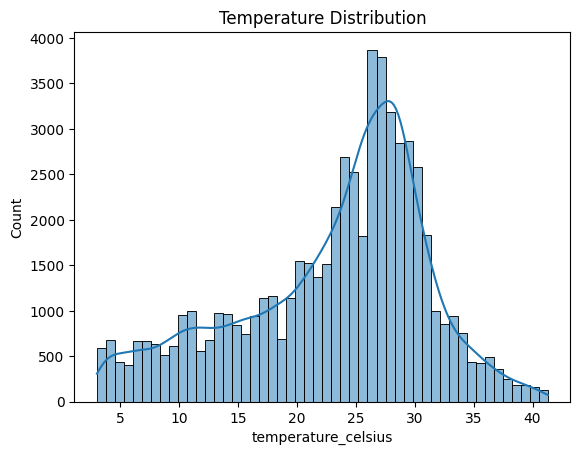

In [80]:
# EDA: Visualizations
# Temperature Distribution
sns.histplot(df['temperature_celsius'], bins=50, kde=True)
plt.title("Temperature Distribution")
plt.show()

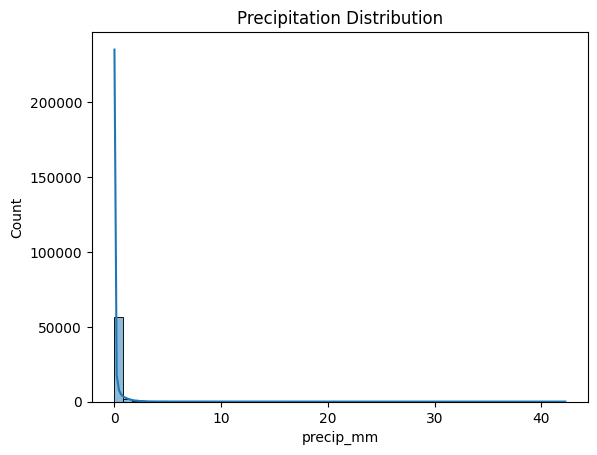

In [81]:
# Precipitation Distribution
sns.histplot(df['precip_mm'], bins=50, kde=True)
plt.title("Precipitation Distribution")
plt.show()

In [82]:
# Correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

In [83]:
# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

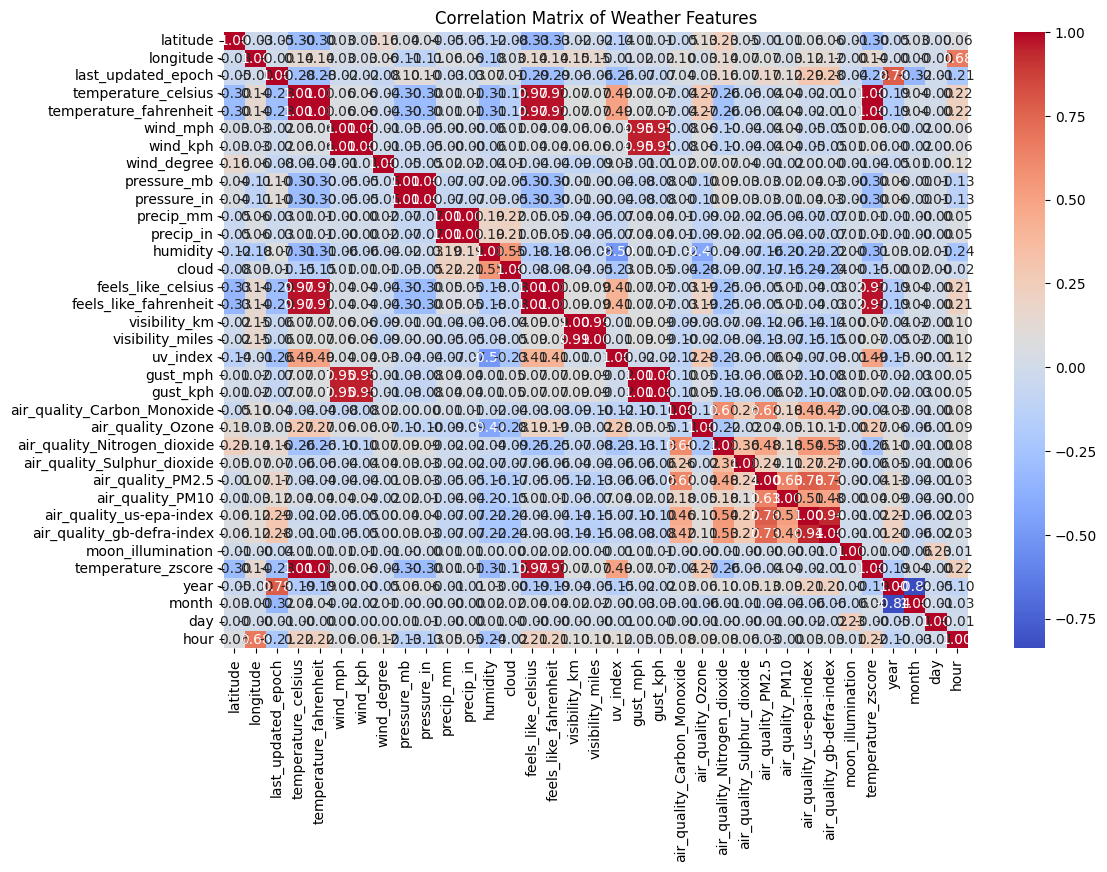

In [84]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Weather Features")
plt.show()

In [85]:
# Split data for forecasting 
X = df[['year', 'month', 'hour', 'latitude', 'longitude']]
y = df['temperature_celsius']

In [86]:
# Machine learning model: Linear Regression 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

In [87]:
# Evaluate Linear Regression model
print("Linear Regression Model Evaluation:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))

Linear Regression Model Evaluation:
MSE: 49.559720632276964
MAE: 5.612454063954888
R2: 0.22474587532005652


In [88]:
# Time Series Model: Holt-Winters Exponential Smoothing
train_size = int(len(df) * 0.8)
train, test = df['temperature_celsius'][:train_size], df['temperature_celsius'][train_size:]

holt_winters_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
holt_winters_fit = holt_winters_model.fit()
predictions = holt_winters_fit.forecast(len(test))

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_in

In [89]:
# Evaluate Time Series Model
mae_ts = mean_absolute_error(test, predictions)
mse_ts = mean_squared_error(test, predictions)
print("\nTime Series Model Evaluation (Holt-Winters):")
print("MAE:", mae_ts)
print("MSE:", mse_ts)


Time Series Model Evaluation (Holt-Winters):
MAE: 84.40426303606078
MSE: 9470.779679048099


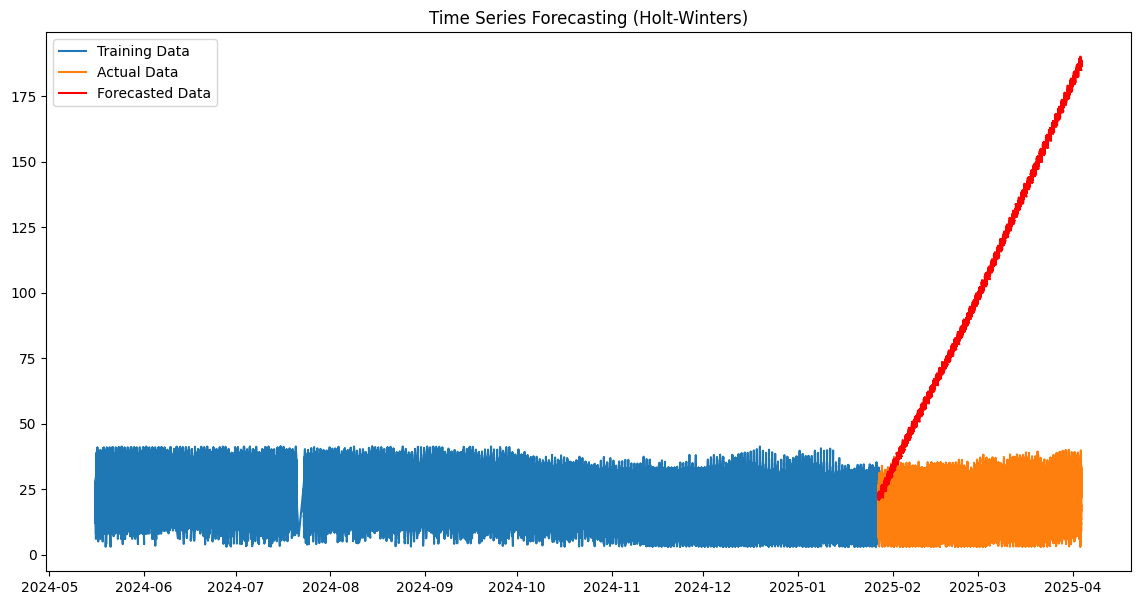

In [90]:
# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='red')
plt.title("Time Series Forecasting (Holt-Winters)")
plt.legend()
plt.show()

In [91]:
# Errors for training data: Comparing training data to model's predictions
train_predictions = holt_winters_fit.fittedvalues
mae_train = mean_absolute_error(train, train_predictions)
mse_train = mean_squared_error(train, train_predictions)

# Print errors
print("\nError Metrics:")
print("Training Data (Holt-Winters):")
print(f"MAE (Training Data): {mae_train:.2f}")
print(f"MSE (Training Data): {mse_train:.2f}")


Error Metrics:
Training Data (Holt-Winters):
MAE (Training Data): 6.04
MSE (Training Data): 56.78


In [92]:
# Errors for actual data: Comparing actual test data to forecasted predictions
mae_test = mean_absolute_error(test, predictions)
mse_test = mean_squared_error(test, predictions)

print("\nActual vs Forecasted Data (Holt-Winters):")
print(f"MAE (Test Data - Forecasted): {mae_test:.2f}")
print(f"MSE (Test Data - Forecasted): {mse_test:.2f}")



Actual vs Forecasted Data (Holt-Winters):
MAE (Test Data - Forecasted): 84.40
MSE (Test Data - Forecasted): 9470.78
